# Usage of our interface for comparison

In this notebook, we describe our interface for comparing different optimization algorithms. 

You can compare the optimization algorithms by running our interface `scripts/ph_optimization.py` 
or calling the function `ph_opt_main` in `scripts/ph_optimization.py`.

To customize them, you need to appropriate set the parameters in `OptConfig` class in `scripts/ph_optimization.py`.
For the details on the parameters of `OptConfig`, please refer to `README.md`.

In the following, we show some remarks to change the parameters of `OptConfig`, 
and the way to visualize the results.

First of all, we need to add paths of the scripts.

In [ ]:
cur_dir = %pwd
if cur_dir.split("/")[-1] != "notebooks":
    %cd notebooks

In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append("..")
sys.path.append("../scripts")

## Table of Contents
1. [How to generate the data](##How-to-generate-the-data)
1. [How to implement the loss function](##How-to-implement-the-loss-function)
1. [How to use ph_opt_main](##How-to-use-ph_opt_main)

## How to generate the data

To specify the way to generate the data for the function `ph_opt_main`, ***you need to implement it as a function***.
The function should take only one argument, `num_pts` (the number of data points to generate), and return `numpy.ndarray` of shape `(num_data, num_pts, 2)`.
Here, `num_data` is the number of data to generate, which has to be larger than or equal to `num_trials` set in `OptConfig`.

THe following is the function to generate data as is done in `notebooks/basic_usage.ipynb`.

In [6]:
import numpy as np

def large_hole_and_small_hole(num_pts: int) -> np.ndarray:
    small_num_pts, large_num_pts = num_pts//2, num_pts - num_pts//2
    X_list = []
    for k in range(1000):
        theta = np.random.rand(small_num_pts) * 2 * np.pi
        small = np.array([-1.5 + 0.5 * np.cos(theta), 0.5 * np.sin(theta)]).T
        theta = np.random.rand(large_num_pts) * 2 * np.pi
        large = np.array([+1.5 + 1.0 * np.cos(theta), 1.0 * np.sin(theta)]).T
        X = np.concatenate([small, large], axis=0)
        X_list.append(X)
    data = np.stack(X_list, axis=0) + np.random.randn(1000, num_pts, 2) * 0.1
    return data

## How to implement the loss function

As we stated in `notebooks/basic_usage.ipynb`, you can implement your favorite loss function.

When implementing the class that represents the loss, we need to be careful about the following points:
- The class should inherit the `PersistenceBasedLoss` class in `scripts/persistence_based_loss.py`.
- We have to implement the `__call__` method, which takes a point cloud and `RipsPH` object as input and returns the loss value.
Moreover, the class need to have `get_rph` decorator.
- We have to implement the `get_direction` method. In this method, 

`RipsPH` is the class define in `scripts/lib/ph_computation_libirary.py`.
The object of `RipsPH` class has the information of the persistent homology of the point cloud.
Basically, the following two methods can be used to implement the loss function:
- `get_barcode`: obtain barcode with the format of list, np.ndarray or torch.Tensor.
- `get_differentiable_barcode`: obtain barcode with the format of differentiable torch.Tensor.
- `get_bar_object_list`: obtain barcode as a list of `Bar` objects. Please refer to `scripts/lib/ph_compute_library.py` for the definition of `Bar` class.

We use wasserstein distance as the loss function here.

In [7]:
from scripts.persistence_based_loss import WassersteinLoss

## How to use ph_opt_main

In the following code, we specify 
- the way to generate data (`large_hole_small_hole`); 
- the loss (`WassersteinLoss`);
- the regularization (`CircleRegularization`);, 

and perform experiments for multiple `lr` parameters.
Since it takes a long time to run the code, it is recommended to run the code in the independent python script.
For this reason, we omit the output of the next cell.

In [8]:
import torch
from scripts.regularization import Regularization

class CircleRegularization(Regularization):
    def __init__(self, center: torch.Tensor, radius: float):
        self.center: torch.Tensor = center
        self.radius: float = radius
        assert self.center.shape == (2,)
    
    def __call__(self, X: torch.Tensor) -> torch.Tensor:
        return torch.sum(torch.relu(torch.norm(X - self.center, dim=1) - self.radius))
    
    ### The following is only necessary when you use Continuation (or use reg_proj=True option in GD/BigStep). ###
    def projection(self, X: torch.Tensor) -> torch.Tensor:
        if torch.all(torch.norm(X - self.center, dim=1)) <= self.radius:
            return X
        return self.center + self.radius * (X - self.center) / torch.norm(X - self.center, dim=1, keepdim=True)

In [10]:
from scripts.ph_optimization import ph_opt_main, OptConfig
import matplotlib.pyplot as plt

method_list = ["gd", "continuation", "bigstep"]
lr_list = [1e-3 * (4**i) for i in range(5)]
num_epoch = 100

In [ ]:
##### We commented out the following and run in the other script because it takes a long time to run. #####
for method in method_list:
    for lr in lr_list:
        config = OptConfig(
            exp_name=f"{method}_lr={lr}", 
            save_dirpath=f"../results/sample/from_notebook/{method}_lr{lr}",
            data_func=large_hole_and_small_hole,
            num_trial=5, 
            num_epoch=num_epoch,
            loss_obj=WassersteinLoss(dim_list=[1], desirable_pd=[torch.tensor([[0, 3]])], order=2),
            regularization_obj=CircleRegularization(center=torch.tensor([0, 0]), radius=3),
            method=method, 
            lr=lr, 
            reg_proj=(method=="continuation"), 
        )
        ph_opt_main(config)
        plt.close("all")

Finally, we visualize the results.

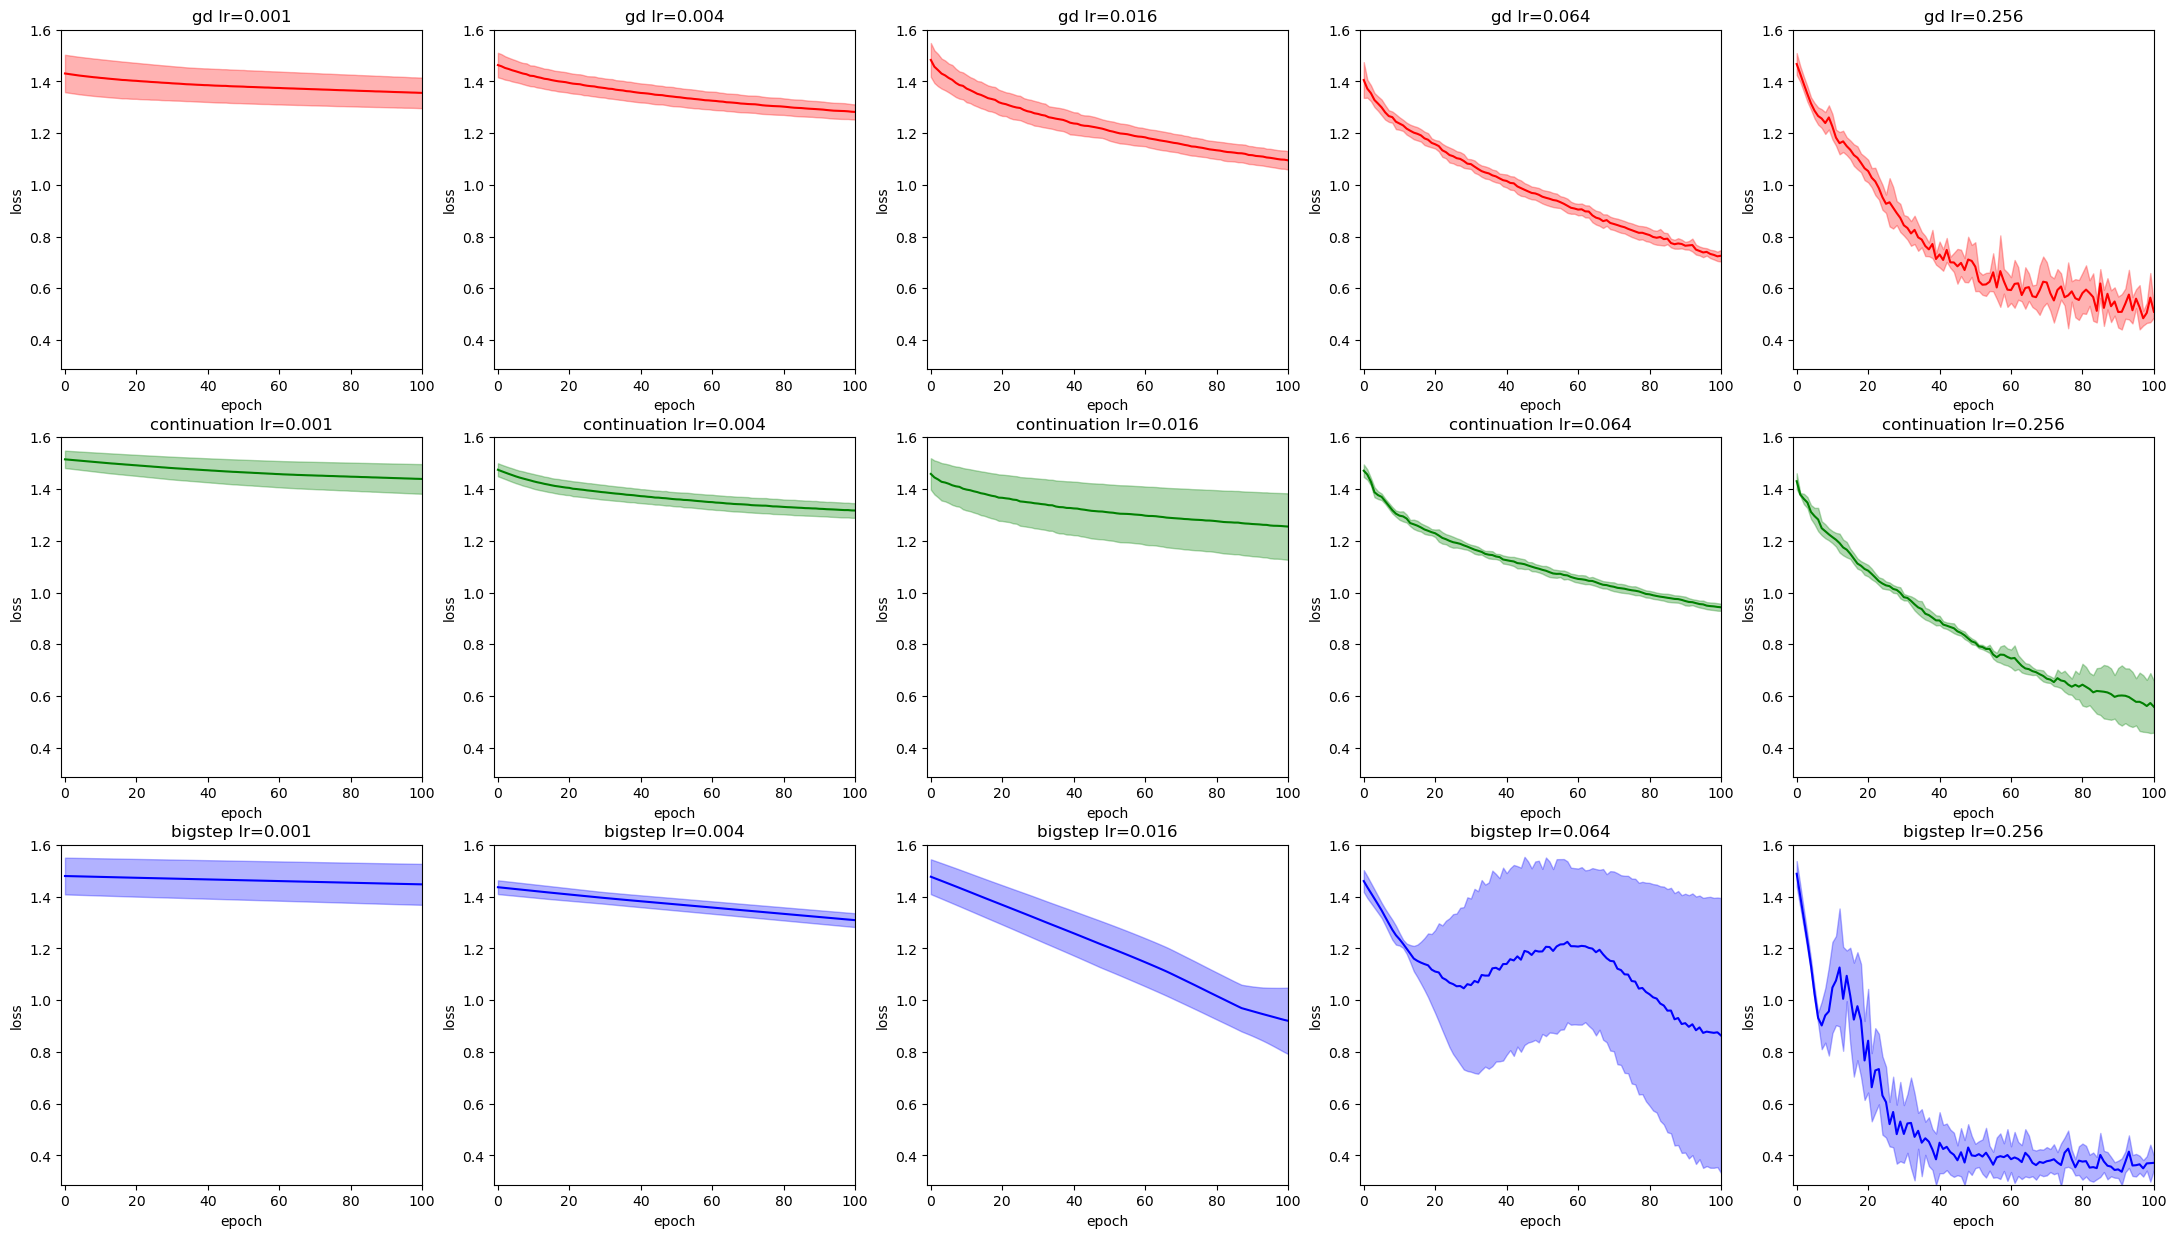

In [11]:
# visualize the result
import pickle

color_list = ["red", "green", "blue"]
loss_history_mean = [[None]*5 for _ in range(3)]
loss_history_std = [[None]*5 for _ in range(3)]
loss_min = 1.6
for i, method in enumerate(method_list):
    for j, lr in enumerate(lr_list):
        with open(f"../results/sample/from_notebook/{method}_lr{lr}/result_dict.pkl", "rb") as f:
            result_dict = pickle.load(f)
        loss_history_list = result_dict["loss_history"]
        loss_history_mat = np.stack(loss_history_list, axis=0) # (num_trial, num_epoch+1)
        loss_history_mean[i][j] = np.mean(loss_history_mat, axis=0)
        loss_history_std[i][j] = np.std(loss_history_mat, axis=0)
        loss_min = min(loss_min, np.min(loss_history_mean[i][j]))

fig, axes = plt.subplots(3, 5, figsize=(27, 15))
for i, method in enumerate(method_list):
    for j, lr in enumerate(lr_list):
        loss_mean = loss_history_mean[i][j]; loss_std = loss_history_std[i][j]
        ax = axes[i, j]
        ax.set_title(f"{method} lr={lr}")
        ax.set_xlim(-1, num_epoch)
        ax.set_ylim(loss_min - 0.05, 1.6)
        ax.plot(loss_mean, c=color_list[i])
        ax.fill_between(np.arange(num_epoch+1), loss_mean-loss_std, loss_mean+loss_std, color=color_list[i], alpha=0.3)
        ax.set_xlabel("epoch"); ax.set_ylabel("loss")

plt.show()